In [1]:
import igraph as ig
import geopandas as gpd
import itertools as it

import numpy as np
import pickle
from pathlib import Path
from matplotlib import pyplot as plt

# Graph

In [2]:
g = ig.Graph(directed=True)

In [3]:
V_O = {f'RC{i+1}':i for i in range(3)}
V_O_attr = {
    'name': [e for e in V_O.keys()],
    'x': [0,2,1],
    'y': [0,0,1],
    'color': ['red','purple','red'],
    'type': 'res_node',
}
g.add_vertices(V_O.values(), V_O_attr)

In [4]:
V_P = {f'PT{i+1}':e for i,e in enumerate(range(3,6))}
V_P_attr = {
    'name': [e for e in V_P.keys()],
    'x': [0,2,1],
    'y': [0,0,1],
    'color': 'blue',
    'type': 'pt_node',
}
g.add_vertices(V_P.values(), V_P_attr)

In [5]:
V_D = {f'POI{i+1}':e for i,e in enumerate(range(6,9))}
V_D_attr = {
    'name': [e for e in V_D.keys()],
    'x': [0,2,1],
    'y': [0,0,1],
    'color': 'green',
    'type': 'poi_node',
}
g.add_vertices(V_D.values(), V_D_attr)

## PTN Edges

In [6]:
# Speeds
WALKING_SPEED = 5  # units per hour
BUS_SPEED = 100  # units per hour
TRAIN_SPEED = 1000  # units per hour

In [7]:
def compute_dist_from_es(es: list):
    positions = [(g.vs[e[0]]['x'], g.vs[e[0]]['y'], g.vs[e[1]]['x'], g.vs[e[1]]['y']) for e in es]
    pos_arr = np.array(positions)
    return np.sqrt((pos_arr[:,[0,2]].max(axis=1)-pos_arr[:,[0,2]].min(axis=1))**2+
                   (pos_arr[:,[1,3]].max(axis=1)-pos_arr[:,[1,3]].min(axis=1))**2)

### Walking

In [8]:
E_WALK = list(it.product(V_O.values(),V_P.values())) +\
         list(it.product(V_P.values(), V_D.values())) +\
         list(it.product(V_O.values(), V_D.values()))
distances_walk = compute_dist_from_es(E_WALK)
E_WALK_attr = {
    'distance': distances_walk,
    'tt': (distances_walk * 1/WALKING_SPEED) * 60,
    'weight': (distances_walk * 1/WALKING_SPEED) * 60,
    'color': 'gray',
    'type': 'walk',
}
g.add_edges(E_WALK, E_WALK_attr)

### PT

In [9]:
E_BUS = [
    (V_P['PT1'],V_P['PT2']),  # Bus_line_1
    (V_P['PT1'],V_P['PT3']),  # Bus_line_2
    (V_P['PT3'],V_P['PT2']),  # Bus_line_3
]
distances_bus = compute_dist_from_es(E_BUS)
E_BUS_attr = {
    'name': ['Bus_line_1', 'Bus_line_2', 'Bus_line_3'],
    'distance': distances_bus,
    'tt': (distances_bus * 1/BUS_SPEED) * 60,
    'weight': (distances_bus * 1/BUS_SPEED) * 60,
    'color': ['blue','red','green'],
    'type': 'bus'
}
g.add_edges(E_BUS, E_BUS_attr)

In [10]:
distances_bus

array([2.        , 1.41421356, 1.41421356])

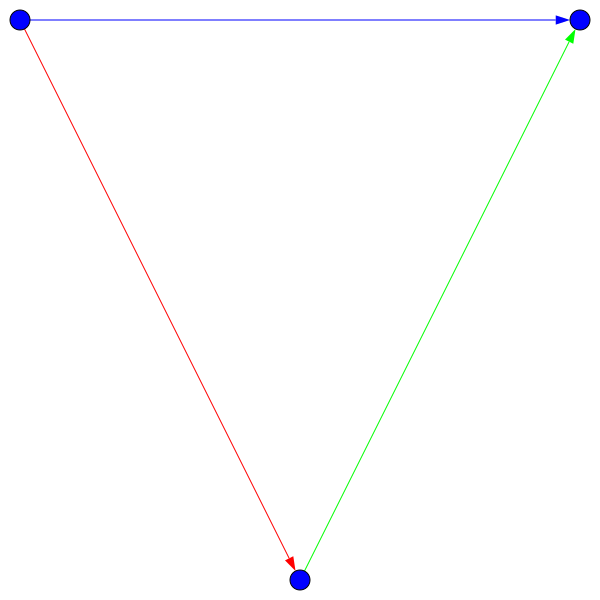

In [11]:
# fig, ax = plt.subplots(figsize=(5,5))
ig.plot(g.subgraph_edges(g.es.select(type_ne='walk')))

In [12]:
g.es['active'] = 1

In [13]:
g.write_picklez('/home/rico/Documents/thesis/eda/notebooks/synthetic_dataset_4/graph.picklez')
g.write_picklez('/home/rico/Documents/thesis/experiments/base_data/graph_4.picklez')

# Reward Dict
As we will be using this dataset with a custom reward, we will compile the reward dict here.

In [14]:
edge_set = [e.index for e in g.es.select(type_ne='walk')]
possible_configurations = []

for i in range(len(edge_set)+1):
    possible_configurations.extend(list(it.combinations(edge_set, i)))

print("List of all possible configurations of the graph:", possible_configurations)

List of all possible configurations of the graph: [(), (27,), (28,), (29,), (27, 28), (27, 29), (28, 29), (27, 28, 29)]


In [15]:

rewards = {
    (): 100,
    (27,): 0,          # blue
    (28,): 30,         # red
    (29,): 0,          # green
    (27, 28): 20,      # blue, red
    (27, 29): 45,      # blue, green
    (28, 29): 30,      # red, green
    (27, 28, 29): 30   # blue, red, green
}

In [16]:
pickle.dump(rewards, open(Path("/home/rico/Documents/thesis/eda/notebooks/synthetic_dataset_4/reward_dict.pkl"), "wb"))
pickle.dump(rewards, open(Path("/home/rico/Documents/thesis/experiments/base_data/reward_dict_4.pkl"), "wb"))